#Importing Libraries

In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2                     
import os                  
from random import shuffle
from tqdm import tqdm  
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

#Mounting Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!ls drive

MyDrive


## Loading Images in Directory

In [ ]:
# setting path of directory
B_DIR = "/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/train/"
M_DIR =  "/content/drive/My Drive/skin_cancer_dataset/Melanoma/train/"
N_DIR = "/content/drive/My Drive/skin_cancer_dataset/Nevus/train/"


# storing all the files from directories PARA_DIR and NORM_DIR to Pimages and Nimages for accessing images directly
Bimages = os.listdir(B_DIR)
Mimages = os.listdir(M_DIR)
Nimages = os.listdir(N_DIR)

## Checking sample images

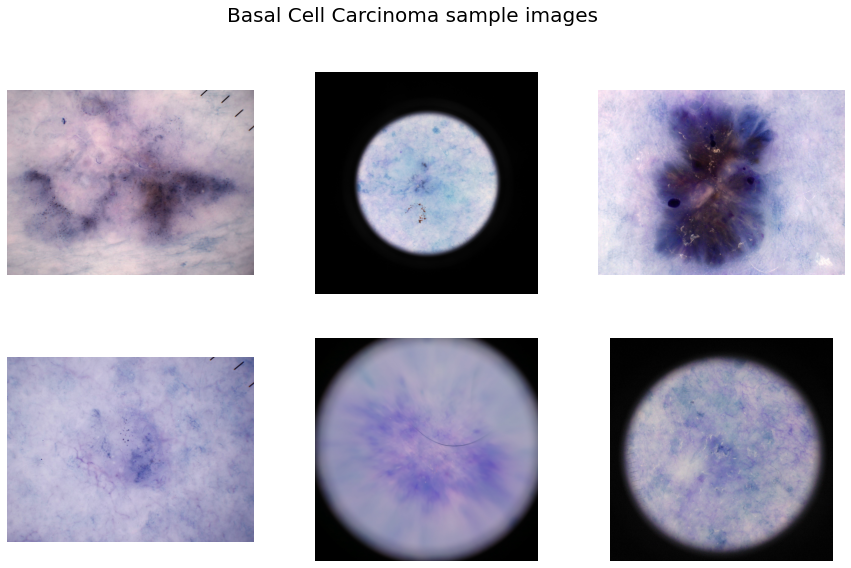

In [ ]:
sample_parasite = random.sample(Bimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/train/" +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Basal Cell Carcinoma sample images',fontsize=20)
plt.show()

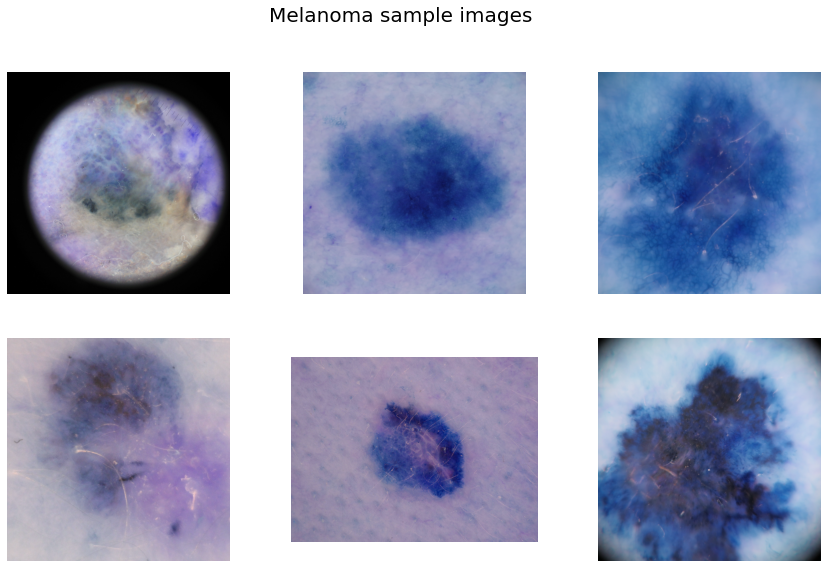

In [ ]:
sample_parasite = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Melanoma sample images',fontsize=20)
plt.show()

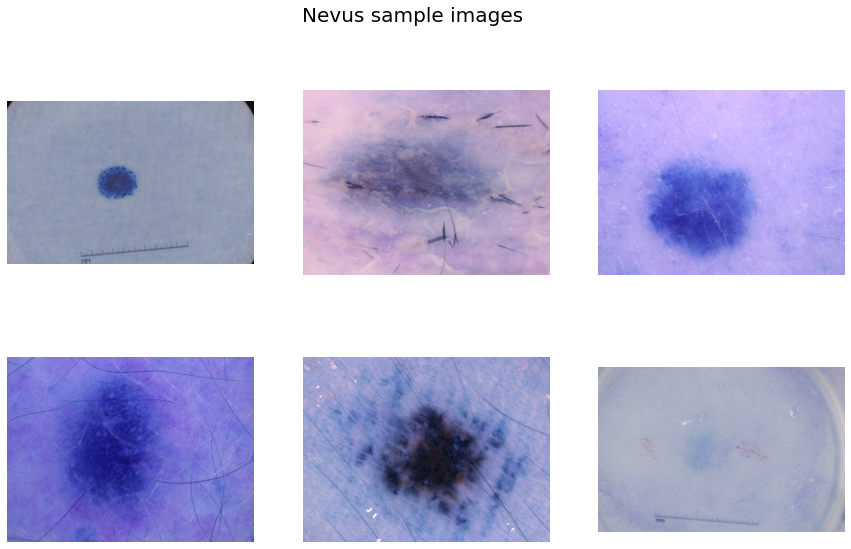

In [ ]:
sample_parasite = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(N_DIR +sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Nevus sample images',fontsize=20)
plt.show()

## Data Preparation - Loading Images and Labels

In [ ]:
data=[]
labels=[]
Basal=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/train/")
for a in Basal:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/train/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Melanoma/train/")
for b in Melanoma:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Melanoma/train/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Nevus/train/")
for c in Nevus:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Nevus/train/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/My Drive/skin_cancer_dataset/feats_train",feats)
np.save("/content/drive/My Drive/skin_cancer_dataset/labels_train",labels)

## Loading saved data and labels

In [ ]:
feats=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_train.npy")
labels=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_train.npy")

## Randomizing Data and Labels

In [ ]:
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

In [ ]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

12445


In [ ]:
print(num_classes)

3


## Train Test Split

In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

## Image Data Normalization

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [ ]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

## Image Augmentation

In [ ]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

## Model Building

In [ ]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
BS = 64
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(x_train,y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=30,callbacks=callbacks)

[INFO] training head...
Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 0.5278 - accuracy: 0.7794
Epoch 1: val_loss improved from inf to 8.95273, saving model to .mdl_wts.hdf5
155/155 [==============================] - 1210s 8s/step - loss: 0.5278 - accuracy: 0.7794 - val_loss: 8.9527 - val_accuracy: 0.4166 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8366
Epoch 2: val_loss improved from 8.95273 to 4.63045, saving model to .mdl_wts.hdf5
155/155 [==============================] - 1232s 8s/step - loss: 0.4040 - accuracy: 0.8366 - val_loss: 4.6305 - val_accuracy: 0.4496 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - ETA: 0s - loss: 0.3420 - accuracy: 0.8620
Epoch 3: val_loss did not improve from 4.63045
155/155 [==============================] - 1242s 8s/step - loss: 0.3420 - accuracy: 0.8620 - val_loss: 11.9230 - val_accuracy: 0.3672 - lr: 0.0010
Epoch 4/30
155/155 [======================

## Saving and Loading Model

In [ ]:
model = load_model('.mdl_wts.hdf5')
model.save('/content/drive/My Drive/skin_model/model_v1.h5')


In [ ]:
model = load_model('/content/drive/My Drive/skin_model/model_v1.h5')
# checking the accuracy 
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

78/78 [==============================] - 42s 516ms/step - loss: 0.1177 - accuracy: 0.9795

 Test_Accuracy:- 0.9795098304748535


In [ ]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]

array([9.9999923e-01, 7.1697792e-07, 2.0264856e-09], dtype=float32)

156/156 [==============================] - 43s 273ms/step


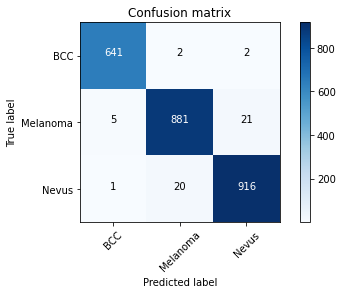

In [ ]:
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_test, axis=1)

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
BS=16
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis=1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [ ]:
predIdxs = model.predict(x_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

# show a nicely formatted classification report
print(classification_report(rounded_labels, predIdxs,target_names=['BCC','Melanoma','Nevus']))

156/156 [==============================] - 44s 280ms/step
              precision    recall  f1-score   support

         BCC       0.99      0.99      0.99       645
    Melanoma       0.98      0.97      0.97       907
       Nevus       0.98      0.98      0.98       937

    accuracy                           0.98      2489
   macro avg       0.98      0.98      0.98      2489
weighted avg       0.98      0.98      0.98      2489



# Plotting ROC AUC

156/156 [==============================] - 45s 291ms/step


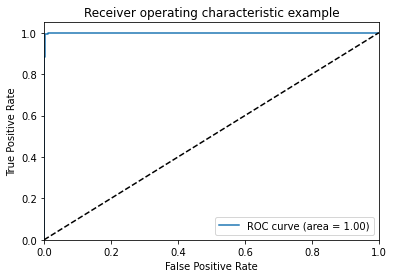

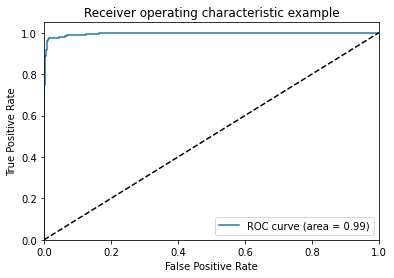

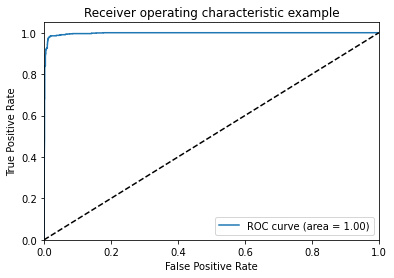

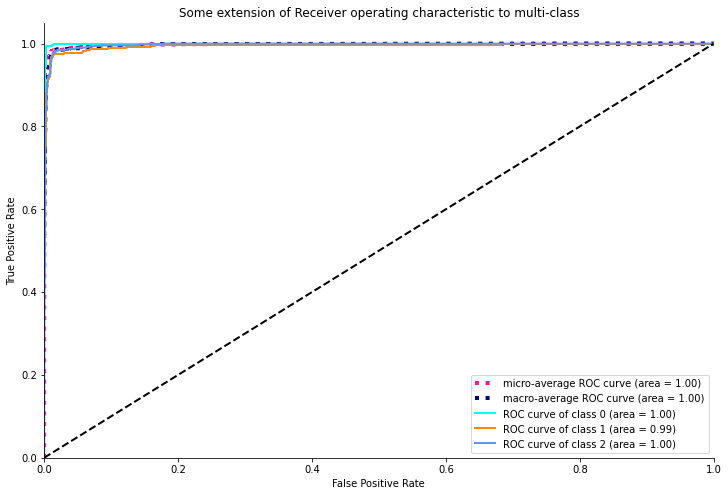

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = np.array(y_test)

n_classes = 3

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

## Preparing Test Data

In [ ]:
data=[]
labels=[]
Basal=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/test/")
for a in Basal:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Basal_cell_carcinoma/test/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Melanoma=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Melanoma/test/")
for b in Melanoma:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Melanoma/test/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
Nevus=os.listdir("/content/drive/My Drive/skin_cancer_dataset/Nevus/test/")
for c in Nevus:
    try:
        image=cv2.imread("/content/drive/My Drive/skin_cancer_dataset/Nevus/test/"+c)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(2)
    except AttributeError:
        print("")

In [ ]:
feats_test=np.array(data)
labels_test=np.array(labels)

np.save("/content/drive/My Drive/skin_cancer_dataset/feats_test",feats_test)
np.save("/content/drive/My Drive/skin_cancer_dataset/labels_test",labels_test)

In [ ]:
feats_test=np.load("/content/drive/My Drive/skin_cancer_dataset/feats_test.npy")
labels_test=np.load("/content/drive/My Drive/skin_cancer_dataset/labels_test.npy")

num_classes=len(np.unique(labels_test))
len_data=len(feats_test)
print(len_data)

150


In [ ]:
x_valid = feats_test.astype('float32')/255
y_valid=to_categorical(labels_test,3)

15/15 [==============================] - 3s 183ms/step


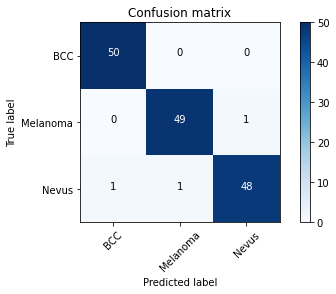

In [ ]:
pred_Y = model.predict(x_valid, batch_size = 10, verbose = True)
rounded_predictions = model.predict(x_valid, batch_size=16, verbose=0)
pred = np.argmax(rounded_predictions,axis=1)
rounded_labels=np.argmax(y_valid, axis=1)
BS=10
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['BCC','Melanoma','Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_valid, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis=1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_valid, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [ ]:
model = load_model('/content/drive/My Drive/skin_model/model_v1.h5')

In [ ]:
img1 = "/content/drive/MyDrive/skin_cancer_dataset/Nevus/test/nv_ISIC_0000081_downsampled.jpg"
img2 ="/content/drive/MyDrive/skin_cancer_dataset/Melanoma/test/melanoma_ISIC_0000412_downsampled.jpg"
img3 = "/content/drive/MyDrive/skin_cancer_dataset/Basal_cell_carcinoma/test/bcc_ISIC_0054605.jpg"

In [ ]:
class_dict ={"Basal_Cell_Carcinoma":0,
             "Melanoma":1,
             "Nevus":2}

In [ ]:
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)[0]
  prediction = sorted(
      [(class_dict[i], round(j*100, 2)) for i, j in enumerate(preds)],
      reverse=True,
      key=lambda x: x[1]
  )
  
  return prediction

In [ ]:
from IPython.display import  display
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!
  # Preprocessing the image
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  pred_cat = [k for k, v in class_dict.items() if v == pred[0]][0]
  
  return pred_cat
    

In [ ]:
pred_image(img1,model)

1/1 [==============================] - 0s 48ms/step


'Nevus'

In [ ]:
pred_image(img2,model)

1/1 [==============================] - 0s 57ms/step


'Melanoma'

In [ ]:
pred_image(img3,model)

1/1 [==============================] - 0s 51ms/step


'Basal_Cell_Carcinoma'

# Plotting Sample Predictions

78/78 [==============================] - 46s 576ms/step


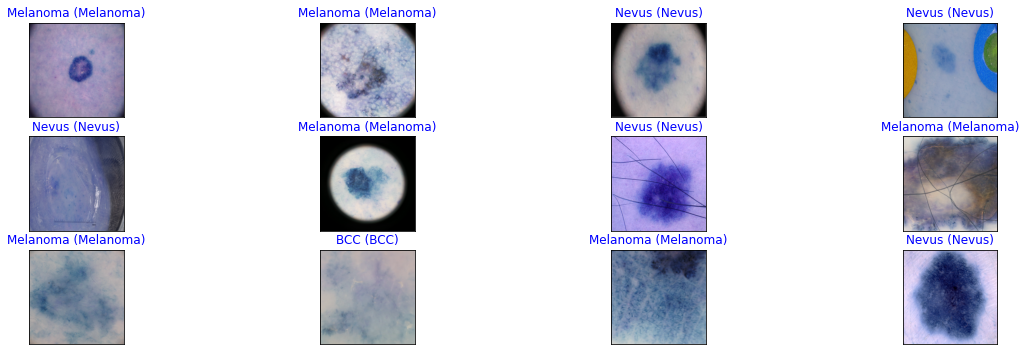

In [ ]:
y_hat = model.predict(x_test)

# define text labels 
skin_labels = ['BCC','Melanoma','Nevus']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(skin_labels[pred_idx], skin_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [ ]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.preprocessing import image
img_path='/content/drive/MyDrive/skin_cancer_dataset/Melanoma/test/melanoma_ISIC_0000412_downsampled.jpg'
img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

In [ ]:
import tensorflow as tf
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Prepare image
img_size=(224,224)
#img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_path='/content/drive/MyDrive/skin_cancer_dataset/Melanoma/test/melanoma_ISIC_0000412_downsampled.jpg'
img = Image.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

# Preprocessing the image
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img.astype('float32')/255

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)

1/1 [==============================] - 0s 67ms/step


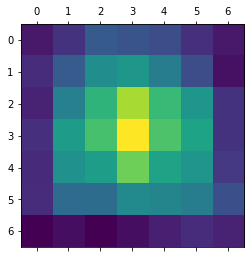

In [ ]:
# Generate class activation heatmap
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

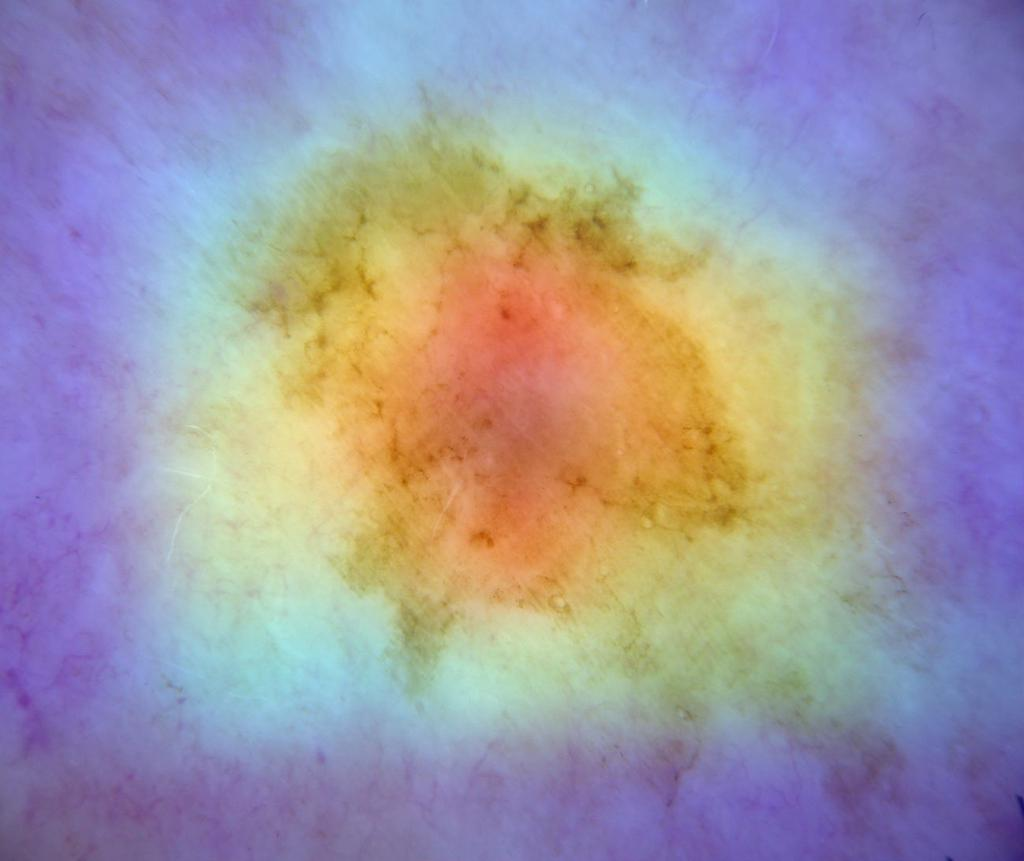

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image as im
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
img_path='/content/drive/MyDrive/skin_cancer_dataset/Melanoma/test/melanoma_ISIC_0000412_downsampled.jpg'
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/drive/MyDrive/skin_cancer_dataset/cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    # img = im.open(img_path).resize((224,224)) #target_size must agree with what the trained model expects!!

    # # Preprocessing the image
    # img = im.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    # img = img.astype('float32')/255

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

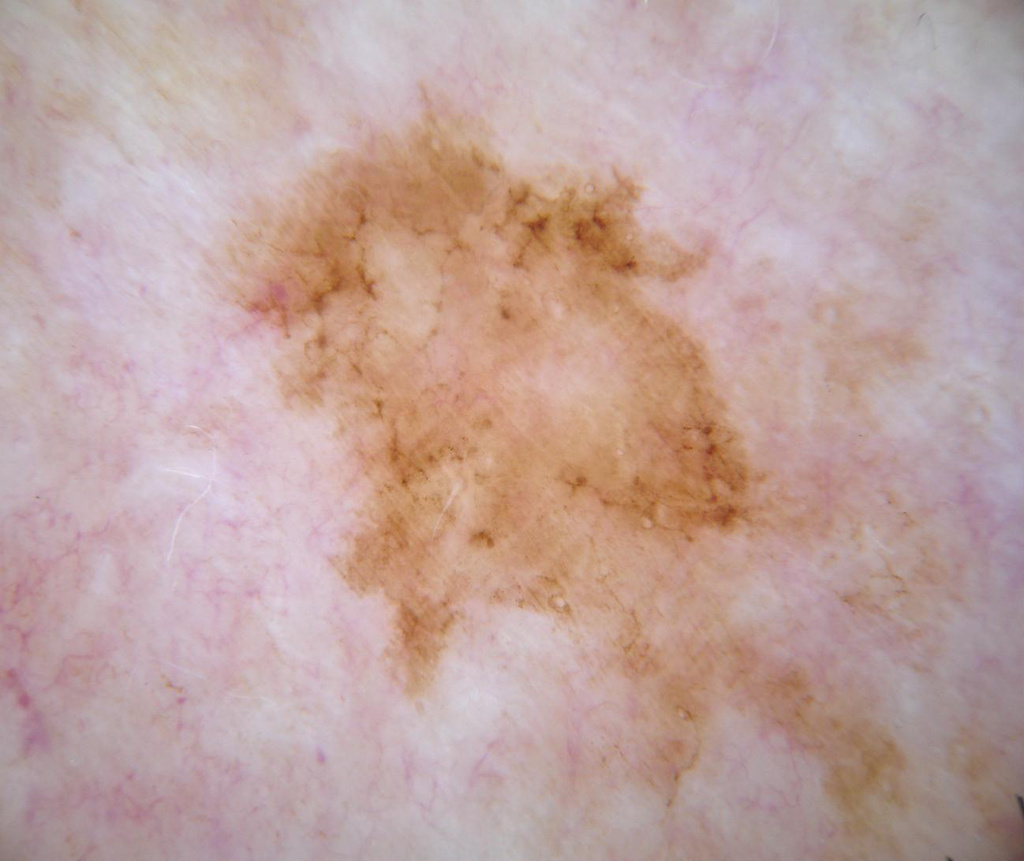

In [ ]:
display(Image(img_path))

In [ ]:
layer_names=[layer.name for layer in model.layers]

In [ ]:
layer_names

['input_1',
 'Conv1',
 'bn_Conv1',
 'Conv1_relu',
 'expanded_conv_depthwise',
 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu',
 'expanded_conv_project',
 'expanded_conv_project_BN',
 'block_1_expand',
 'block_1_expand_BN',
 'block_1_expand_relu',
 'block_1_pad',
 'block_1_depthwise',
 'block_1_depthwise_BN',
 'block_1_depthwise_relu',
 'block_1_project',
 'block_1_project_BN',
 'block_2_expand',
 'block_2_expand_BN',
 'block_2_expand_relu',
 'block_2_depthwise',
 'block_2_depthwise_BN',
 'block_2_depthwise_relu',
 'block_2_project',
 'block_2_project_BN',
 'block_2_add',
 'block_3_expand',
 'block_3_expand_BN',
 'block_3_expand_relu',
 'block_3_pad',
 'block_3_depthwise',
 'block_3_depthwise_BN',
 'block_3_depthwise_relu',
 'block_3_project',
 'block_3_project_BN',
 'block_4_expand',
 'block_4_expand_BN',
 'block_4_expand_relu',
 'block_4_depthwise',
 'block_4_depthwise_BN',
 'block_4_depthwise_relu',
 'block_4_project',
 'block_4_project_BN',
 'block_4_add',
 'block_5_e